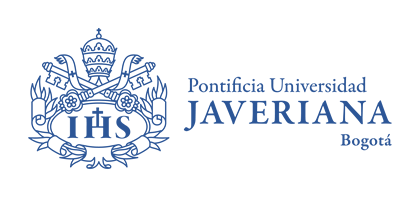

# Aprendizaje de máquina - Taller 2 - Redes neuronales artificiales
En este notebook vamos a explorar implementaciones de redes neuronales feedforward en usando la librería scikit-learn y se propone el enunciado del taller 2 del curso.

## Setup

Importaremos las librerías necesarias para el ejercicio

In [9]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
tf.random.set_seed(1234)



## Redes neuronales artificiales feedforward

Las redes neuronales de alimentación hacia adelante son modelos de aprendizaje de máquina que conectan las unidades neuronales en capas. Estos modelos tienen una capa de entrada que recibe las instancias, una o más capas intermedias o capas ocultas, y una capa de salida o final que da la respuesta según el problema a resolver (regresión o clasificación). Las unidades neuronales de una capa reciben las activaciones de todas las unidades neuronales de la capa anterior y conectan su activación a todas las unidades neuronales de la capa siguiente.


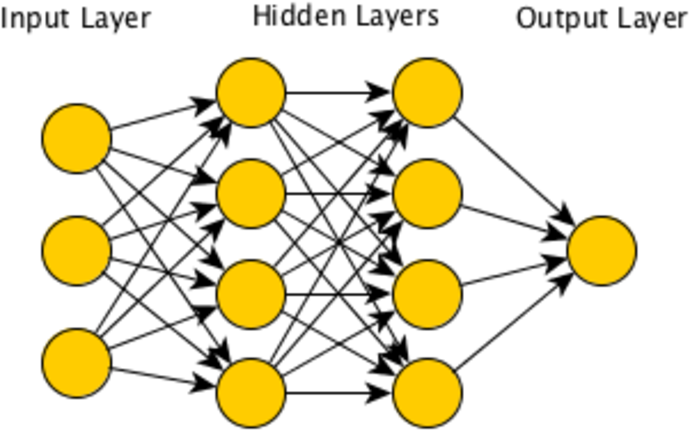

Las redes neuronales artificiales de alimentación hacia adelante son modeladores universales de funciones siempre y cuando se puedan añadir [suficientes unidades neuronales o suficientes capas](https://en.wikipedia.org/wiki/Universal_approximation_theorem)






## Ejercicio - Espirales

Ilustremos inicialmente el uso del modelo de clasificación de redes neuronales utilizando el ejemplo de las espirales que no eran separables por el perceptrón o ADALINE.




In [66]:
N=1000

In [67]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(N)


In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [69]:
X_train.shape

(1600, 2)

In [70]:
X_test.shape

(400, 2)

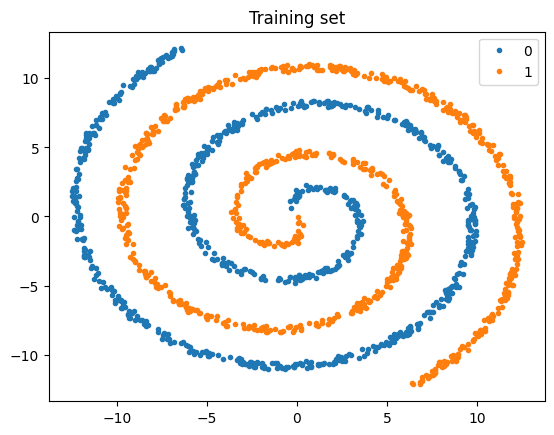

In [71]:
plt.title('Training set')
plt.plot(X_train[Y_train==0,0], X_train[Y_train==0,1], '.', label=0)
plt.plot(X_train[Y_train==1,0], X_train[Y_train==1,1], '.', label=1)
plt.legend()
plt.show()

### Partición datos en entrenamiento, validación y test

A continuación crearemos 3 datasets a partir del dataset no separable linealmente

In [72]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [73]:
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [74]:
len(X_train)

1600

In [75]:
len(X_val)

200

In [76]:
len(X_test)

200

## Construcción del modelo utilizando Tensorflow/Keras

Keras es una librería integrada con TensorFlow para el desarrollo rápido de modelos de aprendizaje de máquina. Keras implementa abstracciones comunes para problemas de aprendizaje profundo como capas, optimizadores, funciones de pérdida y regularización, entre otros.

La clase Sequential ([documentación](https://keras.io/api/models/sequential/)) permite inicializar un modelo feedforward vacío al que vamos a ir añadiendo capas densas

In [77]:
model=keras.Sequential()

En el paquete [layers](https://keras.io/api/layers/) de keras, ya están implementadas diferentes tipos de capas a añadir a una red neuronal. En nuestro caso vamos a usar una capa densa para construir una red feed-forward. Para esto vamos a usar una capa [Dense](https://keras.io/api/layers/core_layers/dense/)

La capa Dense debe recibir el número de unidades neuronales de la capa, en este caso vamos a usar 16 neuronas en una única capa.

Otros parámetros importantes que debemos indicar al inicializar una capa son:


*   activation: El tipo de función de activación de las unidades neuronales de la capa
*   input_shape: Cuando es la primera capa debemos indicar el tamaño de elementos que se esperan (forma del vector que se alimenta como instancia)



In [78]:
model.add(layers.Dense(8, activation='relu', input_shape=(len(X_train[1]),)))

La última capa que se añade al modelo es la capa de salida, en este caso como es un problema de clasificación binaria, debemos usar la activación sigmoide para una única neurona de salida.

In [79]:
model.add(layers.Dense(1, activation='sigmoid'))

Una vez finalizada la construcción del modelo, se pasa a compilarlo. En la compilación establecemos principalmente 2 elementos:

*   El algoritmo de optimización que se va a aplicar. Puede encontrar más información acerca de los opimizadores disponibles en keras siguiendo el siguiente [link](https://keras.io/api/optimizers/#available-optimizers)

*   La función que se va a optimizar y frente a la cuál el framework va a realizar automáticamente las actualizaciones de los pesos, calculando el gradiente. Puede encontrar más información acerca de las funciones de pérdida a optimizar siguiendo el siguiente [link](https://keras.io/api/losses/)

* Funciones que se quieran monitorear en el proceso de aprendizaje. A estas se les conoce como metrics. Puede encontrar más información sobre las métricas de monitoreo en el siguiente [link](https://keras.io/api/metrics/).

En este ejemplo, vamos a optimizar utilizando el algoritmo Adam, y la función de pérdida es la función de errores mínimos cuadrados. Como métrica para monitorear el modelo vamos a usar la raiz del error mínimo cuadrado.



In [80]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Una vez optimizado el modelo, podemos observar la arquitectura de red compilada utilizando la función summary del modelo.

In [81]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 8)                 24        
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Al llamar el método fit del modelo, se comenzará el proceso de feed-forward y backpropagation utilizando el conjunto de datos de entrenamiento, para esto debemos pasar al algoritmo la entrada `train_df[features]` y el resultado esperado `train_df[col_y]`. Además debemos indicar el número de épocas para el que vamos a presentar los datos a la red y el tamaño del mini-batch que se va a usar para calcular el gradiente.

Al ejecutar la siguiente instrucción , keras iniciará el proceso de entrenamiento. Al final de cada época, el framework reportará el valor de la función de pérdida promedio.

In [82]:
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=16)

Epoch 1/300
100/100 [==============================] - 1s 912us/step - loss: 1.1535 - accuracy: 0.5138
Epoch 2/300
100/100 [==============================] - 0s 892us/step - loss: 0.8475 - accuracy: 0.5294
Epoch 3/300
100/100 [==============================] - 0s 880us/step - loss: 0.7270 - accuracy: 0.5519
Epoch 4/300
100/100 [==============================] - 0s 965us/step - loss: 0.6882 - accuracy: 0.5819
Epoch 5/300
100/100 [==============================] - 0s 850us/step - loss: 0.6759 - accuracy: 0.5731
Epoch 6/300
100/100 [==============================] - 0s 878us/step - loss: 0.6699 - accuracy: 0.5844
Epoch 7/300
100/100 [==============================] - 0s 859us/step - loss: 0.6684 - accuracy: 0.5944
Epoch 8/300
100/100 [==============================] - 0s 895us/step - loss: 0.6679 - accuracy: 0.6100
Epoch 9/300
100/100 [==============================] - 0s 852us/step - loss: 0.6668 - accuracy: 0.5975
Epoch 10/300
100/100 [==============================] - 0s 855us/step - l

Grafiquemos la historia de entrenamiento de la red comparando la época con el loss

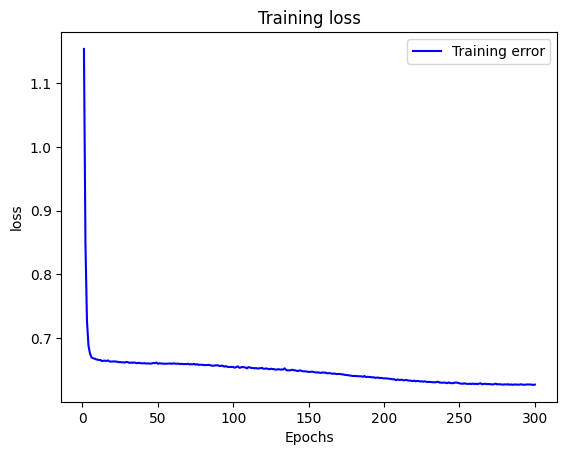

In [83]:
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training error')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

Revisemos en el conjunto de test la medida del error.

In [90]:
predictions= model.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [91]:
predictions.shape

(200, 1)

In [92]:
y_test.shape

(200,)

In [93]:
df_y=pd.DataFrame(np.concatenate((predictions, y_test.reshape(-1,1)),axis=1), columns=['predictions','true'])

In [94]:
df_y

,predictions,true
0,0.453055,0.0
1,0.773777,1.0
2,0.536609,0.0
3,0.292705,1.0
4,0.598327,0.0
...,...,...
195,0.339509,1.0
196,0.481194,0.0
197,0.398891,0.0
198,0.255720,0.0


In [95]:
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)

In [96]:
df_y

,predictions,true,predict_bin
0,0.453055,0.0,0
1,0.773777,1.0,1
2,0.536609,0.0,1
3,0.292705,1.0,0
4,0.598327,0.0,1
...,...,...,...
195,0.339509,1.0,0
196,0.481194,0.0,0
197,0.398891,0.0,0
198,0.255720,0.0,0


In [97]:
pd.value_counts(df_y['true'])

/tmp/ipykernel_35562/4151642742.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_y['true'])


true
1.0    108
0.0     92
Name: count, dtype: int64

In [98]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[49, 43],
       [51, 57]])

2236/2236 [==============================] - 1s 422us/step


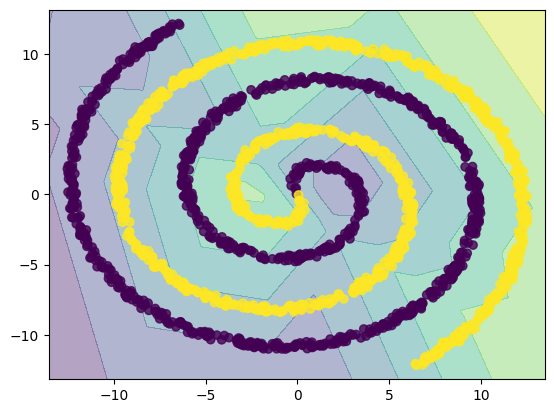

In [99]:
# Código tomado de https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

### Callbacks

Desafortunadamente, la anterior gráfica no nos dice mucho acerca del performance del modelo en los datos de test y nos plantea las siguientes preguntas: ¿Cuántas épocas debemos utilizar?, ¿Será que con menos épocas se logra un mejor resultado, o faltan épocas?. Al utilizar métodos de momento y mini-batches para entrenar se puede obsevar que el error de entrenamiento aunque disminuye en el tiempo puede aumentar en una iteración. Y si estoy "de malas" y justo en el número de épocas suministrada el error sube, ¿estoy obteniendo el mejor modelo?

El conjunto de validación (val_df) se utiliza con el fin de poder seguir más de cerca el proceso de aprendizaje época a época y dar solución a este tipo de inquietudes. La idea es revisar al final de la época el performance del modelo con datos que la red no esta utilizando para disminuir la pérdida, con el fin de diagnosticar de mejor manera si estamos en un escenario de alta varianza o alto sesgo.  Este conjunto se puede configurar de 2 formas diferentes, utilizando los siguientes parámetros:



*   validation_split: Porcentaje de datos del conjunto de entrenamiento que se separa del conjunto de entrenamiento para validar métricas de error.
*   validation_data: Directamente el conjunto de datos si se separó con anterioridad.



In [100]:
del model

In [101]:
# Construyamos de nuevo el modelo para revisar cómo progresa el entrenamiento en validación

model=keras.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(len(X_train[1]),)))
model.add(layers.Dense(1, activation='sigmoid'))
# También vamos a cambiar la tasa de aprendizaje del optimizador, para eso utilizo Adam con un lr diferentes
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/300


50/50 [==============================] - 1s 3ms/step - loss: 0.8466 - accuracy: 0.5263 - val_loss: 0.6923 - val_accuracy: 0.5150
Epoch 2/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6767 - accuracy: 0.5669 - val_loss: 0.6890 - val_accuracy: 0.5500
Epoch 3/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6714 - accuracy: 0.5819 - val_loss: 0.6858 - val_accuracy: 0.5700
Epoch 4/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6744 - accuracy: 0.5688 - val_loss: 0.6932 - val_accuracy: 0.5300
Epoch 5/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6791 - accuracy: 0.5756 - val_loss: 0.6839 - val_accuracy: 0.5550
Epoch 6/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6651 - accuracy: 0.5894 - val_loss: 0.6814 - val_accuracy: 0.6000
Epoch 7/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6656 - accuracy: 0.5806 - val_loss: 0.6856 - val_accuracy: 0.5850
Epoch 8/300
50/50 [======

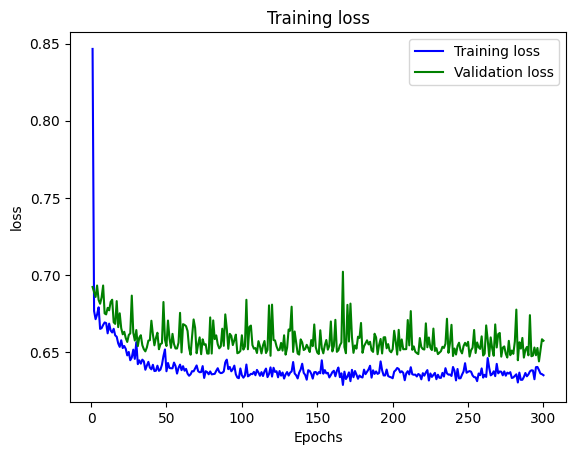

In [102]:
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [103]:
predictions= model.predict(X_test)

7/7 [==============================] - 0s 744us/step


In [104]:
predictions.shape

(200, 1)

In [105]:
y_test.shape

(200,)

In [106]:
df_y=pd.DataFrame(np.concatenate((predictions, y_test.reshape(-1,1)),axis=1), columns=['predictions','true'])

In [107]:
df_y

,predictions,true
0,0.514031,0.0
1,0.842470,1.0
2,0.633824,0.0
3,0.275173,1.0
4,0.587296,0.0
...,...,...
195,0.392491,1.0
196,0.584195,0.0
197,0.352792,0.0
198,0.259377,0.0


In [108]:
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)

In [109]:
df_y

,predictions,true,predict_bin
0,0.514031,0.0,1
1,0.842470,1.0,1
2,0.633824,0.0,1
3,0.275173,1.0,0
4,0.587296,0.0,1
...,...,...,...
195,0.392491,1.0,0
196,0.584195,0.0,1
197,0.352792,0.0,0
198,0.259377,0.0,0


In [110]:
pd.value_counts(df_y['true'])

/tmp/ipykernel_35562/4151642742.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_y['true'])


true
1.0    108
0.0     92
Name: count, dtype: int64

In [111]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[51, 41],
       [49, 59]])

La idea de manejar el proceso de aprendizaje es identificar la arquitectura (número de capas, número de neuronas por capa, y función de activación) adecuada para resolver el problema. Podemos probar varias configuraciones y escoger la que minimice el error de validación.

Antes de hacer esto, es importante aclarar que existen otros hiperparámetros importantes que afectan el error de la red y el proceso de aprendizaje:

* Tamaño del mini-batch  
* Tasa de aprendizaje del algoritmo de optimización
* Parámetros propios del algoritmo de optimización, por ejemplo en Adam el $\beta_1$ y $\beta_2$ que controlan la memoria de la velocidad y momento del algoritmo
* Regularización

Antes de cambiar estos hiperparámetros, estudiemos otras herramientas de Keras que nos permiten manejar de manera más adecuada el proceso de entrenamiento.

Los [callbacks](https://keras.io/api/callbacks/) son funciones que se ejecutan siempre al inicio o final de una época, y al final del proceso de entrenamiento. En el link anterior puede encontrar el modo de uso de estas funciones. Particularmente son importantes los siguientes callbacks:



*   [EarlyStopping](https://keras.io/api/callbacks/early_stopping/)
  El callback de EarlyStopping nos permite parar el algoritmo en el momento en el cuál el error de validación deja de mejorar, de tal forma que no tenemos que esperar todas las épocas ejecutadas inicialmente.

*   [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/)
  El callback de ModelCheckpoint nos permite guardar el mejor modelo visto época a época, de esta forma no nos quedamos con el modelo en el estado de la última época siempre.

Revisemos el uso de estos Callbacks, con el siguiente ejemplo

In [124]:
# Probemos un modelo con 2 capas de 4 unidades neuronales.

# Declaración callback de EarlyStopping (si pasan más de 10 épocas y no mejora el error de validación, se para la ejecución)
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# Declaración callback checkpoint ( se guarda en el directorio /tmp/checkpoints el modelo con el menor error)
callback_checkpoint= ModelCheckpoint(filepath='/tmp/checkpoints',monitor='val_loss', mode='min',save_best_only=True)


model=keras.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(len(X[1]),)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])
# La función fit recibe los callbacks declarados
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val),callbacks=[callback_early, callback_checkpoint])

Epoch 1/300
49/50 [============================>.] - ETA: 0s - loss: 0.8004 - accuracy: 0.5198 INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 1s 8ms/step - loss: 0.7981 - accuracy: 0.5219 - val_loss: 0.6964 - val_accuracy: 0.5100
Epoch 2/300
45/50 [==========================>...] - ETA: 0s - loss: 0.6786 - accuracy: 0.5576INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.6774 - accuracy: 0.5594 - val_loss: 0.6733 - val_accuracy: 0.5700
Epoch 3/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.5853INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6669 - accuracy: 0.5888 - val_loss: 0.6710 - val_accuracy: 0.5900
Epoch 4/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5931 - val_loss: 0.6773 - val_accuracy: 0.5450
Epoch 5/300
50/50 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.5719INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6677 - accuracy: 0.5719 - val_loss: 0.6689 - val_accuracy: 0.6150
Epoch 6/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6615 - accuracy: 0.5944 - val_loss: 0.6699 - val_accuracy: 0.6150
Epoch 7/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6604 - accuracy: 0.5944 - val_loss: 0.6694 - val_accuracy: 0.6100
Epoch 8/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6615 - accuracy: 0.6031 - val_loss: 0.6703 - val_accuracy: 0.6100
Epoch 9/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.5850 - val_loss: 0.6691 - val_accuracy: 0.6100
Epoch 10/300
 1/50 [..............................] - ETA: 0s - loss: 0.6477 - accuracy: 0.5938INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.6619 - accuracy: 0.5831 - val_loss: 0.6617 - val_accuracy: 0.6150
Epoch 11/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.6187 - val_loss: 0.6697 - val_accuracy: 0.5750
Epoch 12/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6525 - accuracy: 0.6019 - val_loss: 0.6698 - val_accuracy: 0.5350
Epoch 13/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6519 - accuracy: 0.5962 - val_loss: 0.6634 - val_accuracy: 0.6450
Epoch 14/300
50/50 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6369INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.6452 - accuracy: 0.6369 - val_loss: 0.6563 - val_accuracy: 0.5800
Epoch 15/300
49/50 [============================>.] - ETA: 0s - loss: 0.6434 - accuracy: 0.6186INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.6422 - accuracy: 0.6212 - val_loss: 0.6464 - val_accuracy: 0.6250
Epoch 16/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6400 - accuracy: 0.6276INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 1s 11ms/step - loss: 0.6404 - accuracy: 0.6256 - val_loss: 0.6416 - val_accuracy: 0.6150
Epoch 17/300
49/50 [============================>.] - ETA: 0s - loss: 0.6360 - accuracy: 0.6397INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6383 - accuracy: 0.6369 - val_loss: 0.6404 - val_accuracy: 0.6500
Epoch 18/300
49/50 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.6288INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6305 - accuracy: 0.6250 - val_loss: 0.6316 - val_accuracy: 0.5850
Epoch 19/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6255 - accuracy: 0.6139INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6252 - accuracy: 0.6169 - val_loss: 0.6316 - val_accuracy: 0.6450
Epoch 20/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6212 - accuracy: 0.6276INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6198 - accuracy: 0.6294 - val_loss: 0.6212 - val_accuracy: 0.6250
Epoch 21/300
49/50 [============================>.] - ETA: 0s - loss: 0.6151 - accuracy: 0.6231INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.6158 - accuracy: 0.6212 - val_loss: 0.6209 - val_accuracy: 0.5600
Epoch 22/300
45/50 [==========================>...] - ETA: 0s - loss: 0.6081 - accuracy: 0.6257INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6101 - accuracy: 0.6256 - val_loss: 0.6142 - val_accuracy: 0.6350
Epoch 23/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6053 - accuracy: 0.6319 - val_loss: 0.6147 - val_accuracy: 0.5800
Epoch 24/300
43/50 [========================>.....] - ETA: 0s - loss: 0.5967 - accuracy: 0.6301INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5960 - accuracy: 0.6306 - val_loss: 0.6022 - val_accuracy: 0.6350
Epoch 25/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5939 - accuracy: 0.6425 - val_loss: 0.6048 - val_accuracy: 0.6000
Epoch 26/300
50/50 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.6131INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5881 - accuracy: 0.6131 - val_loss: 0.5970 - val_accuracy: 0.6250
Epoch 27/300
43/50 [========================>.....] - ETA: 0s - loss: 0.5926 - accuracy: 0.6097INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5857 - accuracy: 0.6250 - val_loss: 0.5934 - val_accuracy: 0.6550
Epoch 28/300
49/50 [============================>.] - ETA: 0s - loss: 0.5784 - accuracy: 0.6352INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5778 - accuracy: 0.6363 - val_loss: 0.5931 - val_accuracy: 0.5850
Epoch 29/300
42/50 [========================>.....] - ETA: 0s - loss: 0.5737 - accuracy: 0.6354INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5792 - accuracy: 0.6300 - val_loss: 0.5904 - val_accuracy: 0.6250
Epoch 30/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5760 - accuracy: 0.6231 - val_loss: 0.5960 - val_accuracy: 0.6500
Epoch 31/300
49/50 [============================>.] - ETA: 0s - loss: 0.5873 - accuracy: 0.6314INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 1s 11ms/step - loss: 0.5870 - accuracy: 0.6319 - val_loss: 0.5878 - val_accuracy: 0.6700
Epoch 32/300
34/50 [===================>..........] - ETA: 0s - loss: 0.5713 - accuracy: 0.6324INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5705 - accuracy: 0.6244 - val_loss: 0.5802 - val_accuracy: 0.6600
Epoch 33/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5710 - accuracy: 0.6456 - val_loss: 0.6021 - val_accuracy: 0.6500
Epoch 34/300
49/50 [============================>.] - ETA: 0s - loss: 0.5691 - accuracy: 0.6199INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5689 - accuracy: 0.6219 - val_loss: 0.5798 - val_accuracy: 0.6250
Epoch 35/300
45/50 [==========================>...] - ETA: 0s - loss: 0.5633 - accuracy: 0.6403INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5616 - accuracy: 0.6388 - val_loss: 0.5778 - val_accuracy: 0.6550
Epoch 36/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.6394 - val_loss: 0.5816 - val_accuracy: 0.6600
Epoch 37/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5601 - accuracy: 0.6250 - val_loss: 0.5817 - val_accuracy: 0.6050
Epoch 38/300
50/50 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.6294INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5627 - accuracy: 0.6294 - val_loss: 0.5650 - val_accuracy: 0.6900
Epoch 39/300
50/50 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.6450INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5522 - accuracy: 0.6450 - val_loss: 0.5610 - val_accuracy: 0.6600
Epoch 40/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5499 - accuracy: 0.6612 - val_loss: 0.5745 - val_accuracy: 0.6650
Epoch 41/300
 1/50 [..............................] - ETA: 0s - loss: 0.5993 - accuracy: 0.6562INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5467 - accuracy: 0.6681 - val_loss: 0.5522 - val_accuracy: 0.6750
Epoch 42/300
45/50 [==========================>...] - ETA: 0s - loss: 0.5410 - accuracy: 0.6729INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5419 - accuracy: 0.6712 - val_loss: 0.5458 - val_accuracy: 0.6650
Epoch 43/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5328 - accuracy: 0.6731 - val_loss: 0.5461 - val_accuracy: 0.6750
Epoch 44/300
 1/50 [..............................] - ETA: 0s - loss: 0.5449 - accuracy: 0.6250INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5335 - accuracy: 0.6831 - val_loss: 0.5329 - val_accuracy: 0.6700
Epoch 45/300
44/50 [=========================>....] - ETA: 0s - loss: 0.5302 - accuracy: 0.6811INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5281 - accuracy: 0.6831 - val_loss: 0.5284 - val_accuracy: 0.6900
Epoch 46/300
39/50 [======================>.......] - ETA: 0s - loss: 0.5268 - accuracy: 0.6875INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5254 - accuracy: 0.6856 - val_loss: 0.5253 - val_accuracy: 0.6750
Epoch 47/300
49/50 [============================>.] - ETA: 0s - loss: 0.5260 - accuracy: 0.6735INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5224 - accuracy: 0.6787 - val_loss: 0.5225 - val_accuracy: 0.7250
Epoch 48/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.6875 - val_loss: 0.5269 - val_accuracy: 0.7250
Epoch 49/300
50/50 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.6938INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.5334 - accuracy: 0.6938 - val_loss: 0.5181 - val_accuracy: 0.7250
Epoch 50/300
43/50 [========================>.....] - ETA: 0s - loss: 0.5128 - accuracy: 0.6839INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 1s 11ms/step - loss: 0.5149 - accuracy: 0.6844 - val_loss: 0.5074 - val_accuracy: 0.7300
Epoch 51/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5148 - accuracy: 0.6888 - val_loss: 0.5107 - val_accuracy: 0.6800
Epoch 52/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.6806 - val_loss: 0.5113 - val_accuracy: 0.7350
Epoch 53/300
 1/50 [..............................] - ETA: 0s - loss: 0.4411 - accuracy: 0.7812INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5037 - accuracy: 0.6944 - val_loss: 0.5063 - val_accuracy: 0.7250
Epoch 54/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.6956 - val_loss: 0.5087 - val_accuracy: 0.7350
Epoch 55/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5084 - accuracy: 0.6913 - val_loss: 0.5130 - val_accuracy: 0.7350
Epoch 56/300
46/50 [==========================>...] - ETA: 0s - loss: 0.5075 - accuracy: 0.6923INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5103 - accuracy: 0.6856 - val_loss: 0.5003 - val_accuracy: 0.7200
Epoch 57/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5060 - accuracy: 0.6919 - val_loss: 0.5059 - val_accuracy: 0.7250
Epoch 58/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.6881 - val_loss: 0.5046 - val_accuracy: 0.7200
Epoch 59/300
48/50 [===========================>..] - ETA: 0s - loss: 0.5032 - accuracy: 0.6810INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5026 - accuracy: 0.6825 - val_loss: 0.4998 - val_accuracy: 0.6800
Epoch 60/300
46/50 [==========================>...] - ETA: 0s - loss: 0.5181 - accuracy: 0.6957INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5172 - accuracy: 0.6919 - val_loss: 0.4959 - val_accuracy: 0.7300
Epoch 61/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5089 - accuracy: 0.6906 - val_loss: 0.5245 - val_accuracy: 0.6850
Epoch 62/300
50/50 [==============================] - 0s 2ms/step - loss: 0.5028 - accuracy: 0.7006 - val_loss: 0.5006 - val_accuracy: 0.6800
Epoch 63/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.6856 - val_loss: 0.5015 - val_accuracy: 0.7150
Epoch 64/300
48/50 [===========================>..] - ETA: 0s - loss: 0.5027 - accuracy: 0.6764INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5015 - accuracy: 0.6756 - val_loss: 0.4958 - val_accuracy: 0.7150
Epoch 65/300
38/50 [=====================>........] - ETA: 0s - loss: 0.5038 - accuracy: 0.6891INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 8ms/step - loss: 0.5025 - accuracy: 0.6862 - val_loss: 0.4953 - val_accuracy: 0.6750
Epoch 66/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4923 - accuracy: 0.6862 - val_loss: 0.4961 - val_accuracy: 0.7200
Epoch 67/300
49/50 [============================>.] - ETA: 0s - loss: 0.4973 - accuracy: 0.6830INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4994 - accuracy: 0.6800 - val_loss: 0.4941 - val_accuracy: 0.6800
Epoch 68/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4938 - accuracy: 0.6913 - val_loss: 0.5004 - val_accuracy: 0.7350
Epoch 69/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.6913 - val_loss: 0.4942 - val_accuracy: 0.7250
Epoch 70/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4919 - accuracy: 0.6844 - val_loss: 0.5114 - val_accuracy: 0.6850
Epoch 71/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4948 - accuracy: 0.6850 - val_loss: 0.5032 - val_accuracy: 0.7100
Epoch 72/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.6925 - val_loss: 0.4949 - val_accuracy: 0.6700
Epoch 73/300
 1/50 [..............................] - ETA: 0s - loss: 0.4600 - accuracy: 0.6562INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.4946 - accuracy: 0.6888 - val_loss: 0.4899 - val_accuracy: 0.7100
Epoch 74/300
49/50 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.6945INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.4901 - accuracy: 0.6925 - val_loss: 0.4800 - val_accuracy: 0.7250
Epoch 75/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.6938 - val_loss: 0.4869 - val_accuracy: 0.7250
Epoch 76/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4833 - accuracy: 0.6981 - val_loss: 0.4869 - val_accuracy: 0.7150
Epoch 77/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4909 - accuracy: 0.6950 - val_loss: 0.5070 - val_accuracy: 0.6700
Epoch 78/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4951 - accuracy: 0.7000 - val_loss: 0.5216 - val_accuracy: 0.7600
Epoch 79/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.7138 - val_loss: 0.4883 - val_accuracy: 0.7150
Epoch 80/300
40/50 [=======================>......] - ETA: 0s - loss: 0.4821 - accuracy: 0.6961INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4832 - accuracy: 0.6944 - val_loss: 0.4780 - val_accuracy: 0.7150
Epoch 81/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.6925 - val_loss: 0.5071 - val_accuracy: 0.6550
Epoch 82/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.6844 - val_loss: 0.4982 - val_accuracy: 0.7050
Epoch 83/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4934 - accuracy: 0.6969 - val_loss: 0.4958 - val_accuracy: 0.6750
Epoch 84/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.6913 - val_loss: 0.5060 - val_accuracy: 0.6950
Epoch 85/300
 1/50 [..............................] - ETA: 0s - loss: 0.5725 - accuracy: 0.5312INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.4947 - accuracy: 0.7025 - val_loss: 0.4739 - val_accuracy: 0.7250
Epoch 86/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7069 - val_loss: 0.4844 - val_accuracy: 0.6750
Epoch 87/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.6969 - val_loss: 0.4782 - val_accuracy: 0.7150
Epoch 88/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4793 - accuracy: 0.6975 - val_loss: 0.4766 - val_accuracy: 0.7050
Epoch 89/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7206 - val_loss: 0.5077 - val_accuracy: 0.7200
Epoch 90/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7088 - val_loss: 0.4787 - val_accuracy: 0.6550
Epoch 91/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4807 - accuracy: 0.6975 - val_loss: 0.4899 - val_accuracy: 0.7000
Epoch 92/300
50/50 

INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 1s 10ms/step - loss: 0.4865 - accuracy: 0.7200 - val_loss: 0.4611 - val_accuracy: 0.7000
Epoch 95/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4790 - accuracy: 0.7088 - val_loss: 0.4626 - val_accuracy: 0.7150
Epoch 96/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.6963 - val_loss: 0.4778 - val_accuracy: 0.7000
Epoch 97/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4912 - accuracy: 0.6881 - val_loss: 0.4629 - val_accuracy: 0.7050
Epoch 98/300
 1/50 [..............................] - ETA: 0s - loss: 0.4862 - accuracy: 0.6250INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4887 - accuracy: 0.7031 - val_loss: 0.4540 - val_accuracy: 0.7200
Epoch 99/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.7156 - val_loss: 0.4670 - val_accuracy: 0.7100
Epoch 100/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4731 - accuracy: 0.7100 - val_loss: 0.5035 - val_accuracy: 0.6900
Epoch 101/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4604 - accuracy: 0.7125 - val_loss: 0.4610 - val_accuracy: 0.7000
Epoch 102/300
46/50 [==========================>...] - ETA: 0s - loss: 0.4721 - accuracy: 0.7188INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4742 - accuracy: 0.7138 - val_loss: 0.4517 - val_accuracy: 0.7400
Epoch 103/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4686 - accuracy: 0.7188 - val_loss: 0.4613 - val_accuracy: 0.7150
Epoch 104/300
49/50 [============================>.] - ETA: 0s - loss: 0.4565 - accuracy: 0.7239INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4549 - accuracy: 0.7250 - val_loss: 0.4513 - val_accuracy: 0.7450
Epoch 105/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4546 - accuracy: 0.7294 - val_loss: 0.4546 - val_accuracy: 0.7700
Epoch 106/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7100 - val_loss: 0.4589 - val_accuracy: 0.7550
Epoch 107/300
 1/50 [..............................] - ETA: 0s - loss: 0.3606 - accuracy: 0.8438INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4724 - accuracy: 0.7131 - val_loss: 0.4394 - val_accuracy: 0.7350
Epoch 108/300
48/50 [===========================>..] - ETA: 0s - loss: 0.4612 - accuracy: 0.7298INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4616 - accuracy: 0.7256 - val_loss: 0.4350 - val_accuracy: 0.7300
Epoch 109/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.7194 - val_loss: 0.4376 - val_accuracy: 0.7600
Epoch 110/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4501 - accuracy: 0.7481 - val_loss: 0.4447 - val_accuracy: 0.7450
Epoch 111/300
 1/50 [..............................] - ETA: 0s - loss: 0.4420 - accuracy: 0.7500INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.4451 - accuracy: 0.7431 - val_loss: 0.4338 - val_accuracy: 0.7550
Epoch 112/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.7319 - val_loss: 0.4382 - val_accuracy: 0.7300
Epoch 113/300
47/50 [===========================>..] - ETA: 0s - loss: 0.4638 - accuracy: 0.7174INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4650 - accuracy: 0.7188 - val_loss: 0.4275 - val_accuracy: 0.7050
Epoch 114/300
46/50 [==========================>...] - ETA: 0s - loss: 0.4538 - accuracy: 0.7405INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.4518 - accuracy: 0.7431 - val_loss: 0.4188 - val_accuracy: 0.7300
Epoch 115/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7331 - val_loss: 0.4263 - val_accuracy: 0.7650
Epoch 116/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.7312 - val_loss: 0.4246 - val_accuracy: 0.7700
Epoch 117/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4463 - accuracy: 0.7356 - val_loss: 0.4247 - val_accuracy: 0.6850
Epoch 118/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4428 - accuracy: 0.7325 - val_loss: 0.4508 - val_accuracy: 0.7250
Epoch 119/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4428 - accuracy: 0.7394 - val_loss: 0.4474 - val_accuracy: 0.7500
Epoch 120/300
 1/50 [..............................] - ETA: 0s - loss: 0.4268 - accuracy: 0.7812INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


INFO:tensorflow:Assets written to: /tmp/checkpoints/assets


50/50 [==============================] - 0s 6ms/step - loss: 0.4621 - accuracy: 0.7406 - val_loss: 0.4086 - val_accuracy: 0.7750
Epoch 121/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4556 - accuracy: 0.7331 - val_loss: 0.4152 - val_accuracy: 0.7600
Epoch 122/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4554 - accuracy: 0.7450 - val_loss: 0.4220 - val_accuracy: 0.7250
Epoch 123/300
50/50 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 0.7312 - val_loss: 0.4216 - val_accuracy: 0.7400
Epoch 124/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.7356 - val_loss: 0.4169 - val_accuracy: 0.7550
Epoch 125/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4421 - accuracy: 0.7344 - val_loss: 0.4267 - val_accuracy: 0.7050
Epoch 126/300
50/50 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 0.7369 - val_loss: 0.4427 - val_accuracy: 0.7550
Epoch 127/300

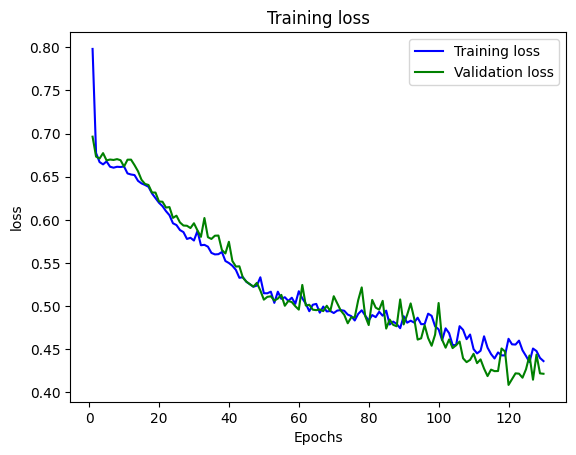

In [125]:
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [126]:
# No olvidar recargar  modelo los mejores pesos encontrados
model.load_weights('/tmp/checkpoints')

2023-10-13 07:44:20.302048: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open /tmp/checkpoints: FAILED_PRECONDITION: /tmp/checkpoints; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [127]:
predictions= model.predict(X_test)

7/7 [==============================] - 0s 810us/step


In [128]:
predictions.shape

(200, 1)

In [129]:
y_test.shape

(200,)

In [130]:
df_y=pd.DataFrame(np.concatenate((predictions, y_test.reshape(-1,1)),axis=1), columns=['predictions','true'])

In [131]:
df_y

,predictions,true
0,0.000642,0.0
1,0.999642,1.0
2,0.518029,0.0
3,0.957563,1.0
4,0.498644,0.0
...,...,...
195,0.436009,1.0
196,0.499364,0.0
197,0.226076,0.0
198,0.105079,0.0


In [132]:
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)

In [133]:
df_y

,predictions,true,predict_bin
0,0.000642,0.0,0
1,0.999642,1.0,1
2,0.518029,0.0,1
3,0.957563,1.0,1
4,0.498644,0.0,0
...,...,...,...
195,0.436009,1.0,0
196,0.499364,0.0,0
197,0.226076,0.0,0
198,0.105079,0.0,0


In [134]:
pd.value_counts(df_y['true'])

/tmp/ipykernel_35562/4151642742.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_y['true'])


true
1.0    108
0.0     92
Name: count, dtype: int64

In [135]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[73, 19],
       [37, 71]])

## Punto 1 (20%)

Esta red aún no presenta un buen comportamiento en el conjunto de datos. Explore los hiperparámetros de la red para realizar una clasificación adecuada, mida el performance utilizando métricas de clasificación. Justifique los pasos que lo llevaron a escoger el modelo utilizando las curvas del proceso de aprendizaje. Grafique las fronteras de decisión encontradas.

In [136]:
X.shape[1]

2

In [137]:
INPUT_SHAPE = X.shape[1]
BATCH_SIZE = 32
EPOCHS = 300

In [168]:
# se crea un modelo para realizar las pruebas
import os
del model_test
model_test = keras.Sequential()
# Teniendo en cuenta que en la imagen de fronteras de decición se observa que no es suficiente 8 neuronas
model_test.add(layers.Dense(32, activation = 'relu', input_shape=(INPUT_SHAPE,)))
model_test.add(layers.Dense(16, activation = 'relu' ))
model_test.add(layers.Dense(8, activation = 'relu'))
model_test.add(layers.Dense(1, activation = 'sigmoid'))
model_test.summary()

checkpoint_path = "./checkpoints/cp_p1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 32)                96        
                                                                 
 dense_62 (Dense)            (None, 16)                528       
                                                                 
 dense_63 (Dense)            (None, 8)                 136       
                                                                 
 dense_64 (Dense)            (None, 1)                 9         
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [163]:
model_test.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])
callback_early_1 = EarlyStopping(monitor='val_loss', patience=10, mode='min')
callback_checkpoint_1 = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

In [164]:
history_p1 = model_test.fit(x=X_train, y=Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),callbacks=[callback_early_1, callback_checkpoint_1])

Epoch 1/300


45/50 [==========================>...] - ETA: 0s - loss: 0.7226 - accuracy: 0.5778 INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 1s 9ms/step - loss: 0.7177 - accuracy: 0.5788 - val_loss: 0.6783 - val_accuracy: 0.5850
Epoch 2/300
46/50 [==========================>...] - ETA: 0s - loss: 0.6654 - accuracy: 0.6114INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6658 - accuracy: 0.6131 - val_loss: 0.6689 - val_accuracy: 0.6000
Epoch 3/300
49/50 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6116INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6573 - accuracy: 0.6119 - val_loss: 0.6645 - val_accuracy: 0.5600
Epoch 4/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6588 - accuracy: 0.6000 - val_loss: 0.6784 - val_accuracy: 0.6500
Epoch 5/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.5813 - val_loss: 0.6768 - val_accuracy: 0.5950
Epoch 6/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6520 - accuracy: 0.5900 - val_loss: 0.6716 - val_accuracy: 0.5650
Epoch 7/300
49/50 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.5784INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6552 - accuracy: 0.5769 - val_loss: 0.6643 - val_accuracy: 0.5200
Epoch 8/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6514 - accuracy: 0.5994 - val_loss: 0.6708 - val_accuracy: 0.5900
Epoch 9/300
49/50 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.6122INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6443 - accuracy: 0.6125 - val_loss: 0.6572 - val_accuracy: 0.5650
Epoch 10/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.5806 - val_loss: 0.6711 - val_accuracy: 0.6150
Epoch 11/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6403 - accuracy: 0.5931 - val_loss: 0.6645 - val_accuracy: 0.5550
Epoch 12/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.5713 - val_loss: 0.6650 - val_accuracy: 0.5700
Epoch 13/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6403 - accuracy: 0.6000 - val_loss: 0.6752 - val_accuracy: 0.5600
Epoch 14/300
50/50 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.5781INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6469 - accuracy: 0.5781 - val_loss: 0.6530 - val_accuracy: 0.4950
Epoch 15/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6334 - accuracy: 0.5844 - val_loss: 0.6670 - val_accuracy: 0.5700
Epoch 16/300
50/50 [==============================] - 0s 1ms/step - loss: 0.6399 - accuracy: 0.5962 - val_loss: 0.6593 - val_accuracy: 0.6200
Epoch 17/300
 1/50 [..............................] - ETA: 0s - loss: 0.5503 - accuracy: 0.7500INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6365 - accuracy: 0.5875 - val_loss: 0.6466 - val_accuracy: 0.6400
Epoch 18/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6252 - accuracy: 0.5625INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6273 - accuracy: 0.5594 - val_loss: 0.6396 - val_accuracy: 0.4950
Epoch 19/300
50/50 [==============================] - 0s 2ms/step - loss: 0.6220 - accuracy: 0.5537 - val_loss: 0.6547 - val_accuracy: 0.5500
Epoch 20/300
48/50 [===========================>..] - ETA: 0s - loss: 0.6079 - accuracy: 0.5462INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 8ms/step - loss: 0.6074 - accuracy: 0.5475 - val_loss: 0.6313 - val_accuracy: 0.5250
Epoch 21/300
43/50 [========================>.....] - ETA: 0s - loss: 0.6066 - accuracy: 0.5552INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.6071 - accuracy: 0.5619 - val_loss: 0.5848 - val_accuracy: 0.6600
Epoch 22/300
45/50 [==========================>...] - ETA: 0s - loss: 0.5852 - accuracy: 0.6160INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 1s 12ms/step - loss: 0.5853 - accuracy: 0.6156 - val_loss: 0.5499 - val_accuracy: 0.6300
Epoch 23/300
44/50 [=========================>....] - ETA: 0s - loss: 0.5206 - accuracy: 0.6960INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.5117 - accuracy: 0.7144 - val_loss: 0.4665 - val_accuracy: 0.8200
Epoch 24/300
39/50 [======================>.......] - ETA: 0s - loss: 0.4158 - accuracy: 0.8686INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.3949 - accuracy: 0.8813 - val_loss: 0.3447 - val_accuracy: 0.8900
Epoch 25/300
41/50 [=======================>......] - ETA: 0s - loss: 0.2406 - accuracy: 0.9627INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 8ms/step - loss: 0.2319 - accuracy: 0.9638 - val_loss: 0.2109 - val_accuracy: 0.9000
Epoch 26/300
39/50 [======================>.......] - ETA: 0s - loss: 0.1399 - accuracy: 0.9720INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 8ms/step - loss: 0.1301 - accuracy: 0.9737 - val_loss: 0.0634 - val_accuracy: 0.9950
Epoch 27/300
39/50 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9864INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9881 - val_loss: 0.0305 - val_accuracy: 0.9950
Epoch 28/300
45/50 [==========================>...] - ETA: 0s - loss: 0.0185 - accuracy: 0.9986INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9987 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 29/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9994 - val_loss: 0.0188 - val_accuracy: 0.9950
Epoch 30/300
47/50 [===========================>..] - ETA: 0s - loss: 0.0080 - accuracy: 0.9987INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 31/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9931 - val_loss: 0.0294 - val_accuracy: 0.9950
Epoch 32/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.9987 - val_loss: 0.0149 - val_accuracy: 0.9950
Epoch 33/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0134 - val_accuracy: 0.9950
Epoch 34/300
46/50 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 35/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 0.9950
Epoch 36/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9987 - val_loss: 0.0136 - val_accuracy: 0.9950
Epoch 37/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.9987 - val_loss: 0.0182 - val_accuracy: 0.9950
Epoch 38/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9950
Epoch 39/300
49/50 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9994    INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 40/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0071 - val_accuracy: 0.9950
Epoch 41/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9950
Epoch 42/300
48/50 [===========================>..] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 43/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9950
Epoch 44/300
50/50 [==============================] - 0s 2ms/step - loss: 8.8066e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9950
Epoch 45/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9950
Epoch 46/300
50/50 [==============================] - 0s 2ms/step - loss: 8.5463e-04 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9950
Epoch 47/300
43/50 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9985    INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.9987 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 48/300
39/50 [======================>.......] - ETA: 0s - loss: 0.0020 - accuracy: 0.9984    INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./checkpoints/cp.ckpt/assets


50/50 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.9987 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 49/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9950
Epoch 50/300
50/50 [==============================] - 0s 2ms/step - loss: 4.7157e-04 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9950
Epoch 51/300
50/50 [==============================] - 0s 2ms/step - loss: 5.0172e-04 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9950
Epoch 52/300
50/50 [==============================] - 0s 2ms/step - loss: 4.1320e-04 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9950
Epoch 53/300
50/50 [==============================] - 0s 2ms/step - loss: 4.1490e-04 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9950
Epoch 54/300
50/50 [==============================] - 0s 2ms/step - loss: 4.1284e-04 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9950

In [165]:
def plot_loss(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss,'g', label='Validation Loss')
    plt.title('Training loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

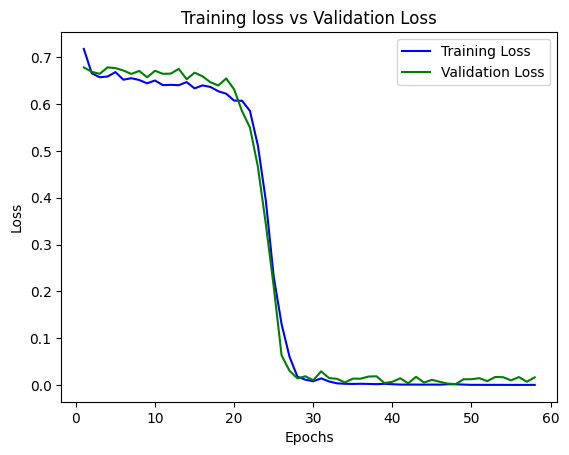

In [166]:
plot_loss(history_p1)


In [167]:
model_test.load_weights(checkpoint_path)

2023-10-13 07:57:27.721917: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./checkpoints/cp.ckpt: FAILED_PRECONDITION: checkpoints/cp.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [157]:

predictions_p1 = model_test.predict(X_test)
predictions_p1 = np.round(predictions_p1) 

7/7 [==============================] - 0s 739us/step


In [158]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_p1)) 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      1.00      1.00       108

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



2236/2236 [==============================] - 1s 467us/step


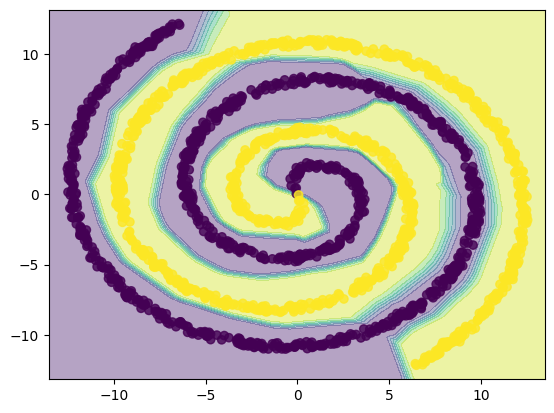

In [159]:
# Código tomado de https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model_test.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model_test.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

## Punto 2 (80%)

Descargue del archivo disponible en Brightspace. Los datos son de una tarea de clasificación misteriosa. Se le han suministrado 2 datasets: public_dataset y quiz.

Ud debe en el taller construir un modelo de redes neuronales que prediga la variable label.

Además de su informe y código que usualmente se deben entregar en el taller, debe entregar un archivo Python ejecutable que lea los pesos de la red creada, lea el archivo quiz.csv y cree un archivo llamado answers.txt con la etiqueta predicha para cada elemento del archivo quiz.csv en orden.

Los 2 grupos con mejor desempeño en el dataset quiz, tendrán bono en la nota del taller 2.


In [170]:
mistery_df = pd.read_csv('public_dataset.csv')

In [171]:
mistery_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,label
count,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,...,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000,517682.000000
mean,0.011376,0.012998,0.015052,0.015996,0.021403,0.021388,0.023731,0.026646,0.030044,0.036582,...,223.324703,212.138174,142.545775,46.407041,155.663966,269.294544,2959.014215,1980.547635,2349.905282,0.004725
std,0.106049,0.113267,0.121759,0.125461,0.144724,0.144673,0.152209,0.161046,0.170707,0.187734,...,19.754795,26.776116,38.271013,58.327113,111.916526,212.378839,280.109423,1324.590848,1559.310449,0.068575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,1859.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,213.000000,198.000000,119.000000,7.000000,58.000000,108.000000,2809.000000,1024.000000,1106.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,226.000000,218.000000,143.000000,30.000000,127.000000,218.000000,2995.000000,1710.000000,1997.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,237.000000,231.000000,168.000000,69.000000,261.000000,384.000000,3163.000000,2550.000000,3327.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,254.000000,254.000000,254.000000,601.000000,360.000000,1397.000000,3858.000000,7173.000000,7117.000000,1.000000


In [174]:
mistery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517682 entries, 0 to 517681
Data columns (total 34 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       517682 non-null  int64
 1   1       517682 non-null  int64
 2   2       517682 non-null  int64
 3   3       517682 non-null  int64
 4   4       517682 non-null  int64
 5   5       517682 non-null  int64
 6   6       517682 non-null  int64
 7   7       517682 non-null  int64
 8   8       517682 non-null  int64
 9   9       517682 non-null  int64
 10  10      517682 non-null  int64
 11  11      517682 non-null  int64
 12  12      517682 non-null  int64
 13  13      517682 non-null  int64
 14  14      517682 non-null  int64
 15  15      517682 non-null  int64
 16  16      517682 non-null  int64
 17  17      517682 non-null  int64
 18  18      517682 non-null  int64
 19  19      517682 non-null  int64
 20  20      517682 non-null  int64
 21  21      517682 non-null  int64
 22  22      517682 non-n

In [192]:
mistery_df['label'].value_counts()

label
0    515236
1      2446
Name: count, dtype: int64

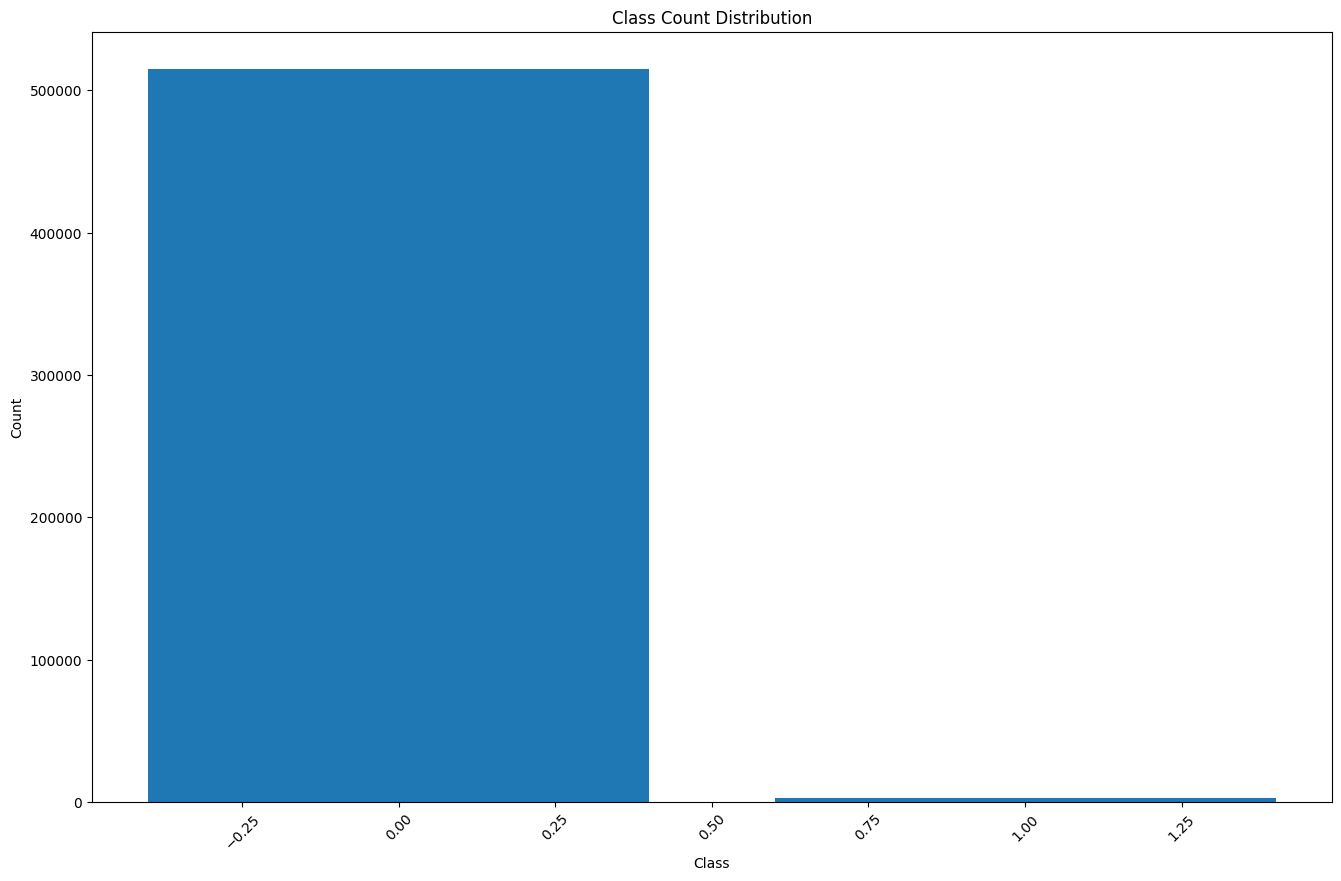

In [191]:
plt.figure(figsize=(16,10))
plt.bar(mistery_df['label'].unique(),mistery_df['label'].value_counts())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count Distribution')
plt.xticks(rotation=45)
plt.show()

In [175]:
mistery_df.loc[:,'label'].value_counts()

label
0    515236
1      2446
Name: count, dtype: int64

In [176]:
quiz_df=pd.read_csv('quiz_v2.csv')

In [177]:
quiz_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
count,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,...,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000
mean,0.010826,0.012736,0.015026,0.015249,0.020912,0.021118,0.023838,0.027796,0.029913,0.036884,...,14.135385,223.260254,212.212957,142.361698,46.590644,155.507943,270.805528,2961.615841,1978.919451,2350.529251
std,0.103484,0.112136,0.121655,0.122544,0.143091,0.143780,0.152545,0.164391,0.170350,0.188479,...,7.511713,19.898346,26.749265,38.297732,58.096625,111.800193,214.061609,278.889308,1322.040956,1559.692115
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,52.000000,0.000000,-161.000000,0.000000,0.000000,1872.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,213.000000,198.000000,119.000000,7.000000,58.000000,108.000000,2813.000000,1025.000000,1106.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.000000,226.000000,218.000000,143.000000,30.000000,127.000000,228.000000,2997.000000,1710.000000,1991.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18.000000,237.000000,231.000000,168.000000,69.000000,259.000000,390.000000,3165.000000,2548.000000,3334.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,62.000000,254.000000,254.000000,254.000000,592.000000,360.000000,1383.000000,3851.000000,7112.000000,7041.000000


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2023-10-15 18:39:03.990102: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 18:39:04.138070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 18:39:04.808779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Cargar los datos
data = pd.read_csv('./public_dataset.csv')

# Extraer las características y la etiqueta
X = data.drop(columns=['label'])
y = data['label']

# Dividir los datos en conjuntos de entrenamiento y validación, 
# Es importante que el muestreo se haga estratificado. 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar los datos
escalador = StandardScaler()
X_train_escalado = escalador.fit_transform(X_train)
X_val_escalado = escalador.transform(X_val)

# Calcular los pesos de las clases
pesos_clases = compute_class_weight('balanced', classes=[0, 1], y=y_train)
diccionario_pesos_clases = {0: pesos_clases[0], 1: pesos_clases[1]}

In [3]:
diccionario_pesos_clases

{0: 0.5023739167564315, 1: 105.81119059785385}

In [33]:
# Construir el modelo de red neuronal
modelo = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_escalado.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               4352      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 15233 (59.50 KB)
Trainable params: 15233 (59.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [35]:
callback_early_p2 = EarlyStopping(monitor='val_loss', patience=10, mode='min')
callback_checkpoint_p2 = ModelCheckpoint(filepath='chekpoints_p2', monitor='val_loss', save_best_only=True, mode='min')
# Compilar el modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)


In [36]:
# Entrenar el modelo
history_p2 = modelo.fit(
    X_train_escalado, y_train,
    validation_data=(X_val_escalado, y_val),
    epochs=100,
    class_weight=diccionario_pesos_clases,
    batch_size=64,
    verbose=1, 
    callbacks=[callback_early_p2, callback_checkpoint_p2]
)

Epoch 1/100
6458/6472 [============================>.] - ETA: 0s - loss: 0.0820 - cross entropy: 0.1072 - Brier score: 0.0313 - tp: 1926.0000 - fp: 16526.0000 - tn: 394833.0000 - fn: 27.0000 - accuracy: 0.9600 - precision: 0.1044 - recall: 0.9862 - auc: 0.9919 - prc: 0.3136INFO:tensorflow:Assets written to: chekpoints_p2/assets


INFO:tensorflow:Assets written to: chekpoints_p2/assets


6472/6472 [==============================] - 16s 2ms/step - loss: 0.0820 - cross entropy: 0.1072 - Brier score: 0.0313 - tp: 1930.0000 - fp: 16552.0000 - tn: 395636.0000 - fn: 27.0000 - accuracy: 0.9600 - precision: 0.1044 - recall: 0.9862 - auc: 0.9919 - prc: 0.3137 - val_loss: 0.0815 - val_cross entropy: 0.0815 - val_Brier score: 0.0251 - val_tp: 486.0000 - val_fp: 3583.0000 - val_tn: 99465.0000 - val_fn: 3.0000 - val_accuracy: 0.9654 - val_precision: 0.1194 - val_recall: 0.9939 - val_auc: 0.9946 - val_prc: 0.4704
Epoch 2/100
6472/6472 [==============================] - 14s 2ms/step - loss: 0.0791 - cross entropy: 0.0914 - Brier score: 0.0267 - tp: 1945.0000 - fp: 14979.0000 - tn: 397209.0000 - fn: 12.0000 - accuracy: 0.9638 - precision: 0.1149 - recall: 0.9939 - auc: 0.9941 - prc: 0.4030 - val_loss: 0.0884 - val_cross entropy: 0.0884 - val_Brier score: 0.0292 - val_tp: 489.0000 - val_fp: 5198.0000 - val_tn: 97850.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9498 - val_precision: 0.08

INFO:tensorflow:Assets written to: chekpoints_p2/assets


6472/6472 [==============================] - 14s 2ms/step - loss: 0.0582 - cross entropy: 0.0788 - Brier score: 0.0217 - tp: 1935.0000 - fp: 10343.0000 - tn: 401845.0000 - fn: 22.0000 - accuracy: 0.9750 - precision: 0.1576 - recall: 0.9888 - auc: 0.9957 - prc: 0.4456 - val_loss: 0.0714 - val_cross entropy: 0.0714 - val_Brier score: 0.0202 - val_tp: 483.0000 - val_fp: 2626.0000 - val_tn: 100422.0000 - val_fn: 6.0000 - val_accuracy: 0.9746 - val_precision: 0.1554 - val_recall: 0.9877 - val_auc: 0.9969 - val_prc: 0.5384
Epoch 7/100
6459/6472 [============================>.] - ETA: 0s - loss: 0.0547 - cross entropy: 0.0716 - Brier score: 0.0202 - tp: 1941.0000 - fp: 10351.0000 - tn: 401068.0000 - fn: 16.0000 - accuracy: 0.9749 - precision: 0.1579 - recall: 0.9918 - auc: 0.9962 - prc: 0.4918INFO:tensorflow:Assets written to: chekpoints_p2/assets


INFO:tensorflow:Assets written to: chekpoints_p2/assets


6472/6472 [==============================] - 15s 2ms/step - loss: 0.0547 - cross entropy: 0.0716 - Brier score: 0.0202 - tp: 1941.0000 - fp: 10368.0000 - tn: 401820.0000 - fn: 16.0000 - accuracy: 0.9749 - precision: 0.1577 - recall: 0.9918 - auc: 0.9962 - prc: 0.4915 - val_loss: 0.0468 - val_cross entropy: 0.0468 - val_Brier score: 0.0147 - val_tp: 481.0000 - val_fp: 1981.0000 - val_tn: 101067.0000 - val_fn: 8.0000 - val_accuracy: 0.9808 - val_precision: 0.1954 - val_recall: 0.9836 - val_auc: 0.9969 - val_prc: 0.5726
Epoch 8/100
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0683 - cross entropy: 0.0750 - Brier score: 0.0204 - tp: 1946.0000 - fp: 10067.0000 - tn: 402121.0000 - fn: 11.0000 - accuracy: 0.9757 - precision: 0.1620 - recall: 0.9944 - auc: 0.9959 - prc: 0.4795 - val_loss: 0.0921 - val_cross entropy: 0.0921 - val_Brier score: 0.0254 - val_tp: 486.0000 - val_fp: 3119.0000 - val_tn: 99929.0000 - val_fn: 3.0000 - val_accuracy: 0.9698 - val_precision: 0.1348 

INFO:tensorflow:Assets written to: chekpoints_p2/assets


6472/6472 [==============================] - 16s 2ms/step - loss: 0.0615 - cross entropy: 0.0704 - Brier score: 0.0190 - tp: 1940.0000 - fp: 9810.0000 - tn: 402378.0000 - fn: 17.0000 - accuracy: 0.9763 - precision: 0.1651 - recall: 0.9913 - auc: 0.9961 - prc: 0.4906 - val_loss: 0.0227 - val_cross entropy: 0.0227 - val_Brier score: 0.0059 - val_tp: 392.0000 - val_fp: 689.0000 - val_tn: 102359.0000 - val_fn: 97.0000 - val_accuracy: 0.9924 - val_precision: 0.3626 - val_recall: 0.8016 - val_auc: 0.9945 - val_prc: 0.4031
Epoch 11/100
6472/6472 [==============================] - 14s 2ms/step - loss: 0.0516 - cross entropy: 0.0695 - Brier score: 0.0180 - tp: 1945.0000 - fp: 9256.0000 - tn: 402932.0000 - fn: 12.0000 - accuracy: 0.9776 - precision: 0.1736 - recall: 0.9939 - auc: 0.9962 - prc: 0.4719 - val_loss: 0.1221 - val_cross entropy: 0.1221 - val_Brier score: 0.0267 - val_tp: 489.0000 - val_fp: 3283.0000 - val_tn: 99765.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9683 - val_precision: 0.12

### Synthetic Minority Oversampling Technique SMOTE
Considerando que el desbalanceo de clases del dataset está afectando la correcta clasificación de de la clase minoritaria, se decide realizar un sobremuestreo para balancear las clases.

In [74]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define dataset

over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_s, y_train_s = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)
counter = Counter(y_train_s)
print(counter)
X_train_escalado = escalador.fit_transform(X_train_s)
X_val_escalado = escalador.transform(X_val)

Counter({0: 412188, 1: 1957})
Counter({0: 412188, 1: 412188})


In [84]:
# Construir el modelo de red neuronal
modelo_p2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_escalado.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),    
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelo_p2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 128)               4352      
                                                                 
 dense_95 (Dense)            (None, 64)                8256      
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 16)                528       
                                                                 
 dense_98 (Dense)            (None, 8)                 136       
                                                                 
 dense_99 (Dense)            (None, 4)                 36        
                                                                 
 dense_100 (Dense)           (None, 1)               

In [85]:
modelo_p2.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)


In [86]:
# Entrenar el modelo
history_p2 = modelo_p2.fit(
    X_train_escalado, y_train_s,
    validation_data=(X_val_escalado, y_val),
    epochs=100,
    batch_size=64,
    verbose=1, 
    callbacks=[callback_early_p2, callback_checkpoint_p2]
)

Epoch 1/100
12881/12881 [==============================] - 30s 2ms/step - loss: 0.0250 - cross entropy: 0.0232 - Brier score: 0.0054 - tp: 411597.0000 - fp: 4713.0000 - tn: 510523.0000 - fn: 1080.0000 - accuracy: 0.9938 - precision: 0.9887 - recall: 0.9974 - auc: 0.9989 - prc: 0.9978 - val_loss: 0.0166 - val_cross entropy: 0.0166 - val_Brier score: 0.0046 - val_tp: 480.0000 - val_fp: 580.0000 - val_tn: 102468.0000 - val_fn: 9.0000 - val_accuracy: 0.9943 - val_precision: 0.4528 - val_recall: 0.9816 - val_auc: 0.9962 - val_prc: 0.8621
Epoch 2/100
12881/12881 [==============================] - 30s 2ms/step - loss: 0.0120 - cross entropy: 0.0120 - Brier score: 0.0027 - tp: 411675.0000 - fp: 2126.0000 - tn: 410062.0000 - fn: 513.0000 - accuracy: 0.9968 - precision: 0.9949 - recall: 0.9988 - auc: 0.9995 - prc: 0.9991 - val_loss: 0.0150 - val_cross entropy: 0.0150 - val_Brier score: 0.0038 - val_tp: 478.0000 - val_fp: 454.0000 - val_tn: 102594.0000 - val_fn: 11.0000 - val_accuracy: 0.9955 - v

In [87]:
#  Guardar los pesos del modelo y el scalaer
modelo_p2.save('classifier.h5')
joblib.dump(escalador, 'mi_scaler.pkl')

/home/danielcrovo/anaconda3/envs/mltf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['mi_scaler.pkl']

In [78]:
modelo_p2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_escalado.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),    
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelo_p2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               8704      
                                                                 
 dense_73 (Dense)            (None, 128)               32896     
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dense_75 (Dense)            (None, 32)                2080      
                                                                 
 dense_76 (Dense)            (None, 16)                528       
                                                                 
 dense_77 (Dense)            (None, 8)                 136       
                                                                 
 dense_78 (Dense)            (None, 1)               

In [79]:
modelo_p2.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
# Entrenar el modelo
history_p2 = modelo_p2.fit(
    X_train_escalado, y_train_s,
    validation_data=(X_val_escalado, y_val),
    epochs=100,
    batch_size=64,
    verbose=1, 
    callbacks=[callback_early_p2, callback_checkpoint_p2]
)

Epoch 1/100
12881/12881 [==============================] - 30s 2ms/step - loss: 0.0237 - cross entropy: 0.0219 - Brier score: 0.0051 - tp: 411618.0000 - fp: 4451.0000 - tn: 510785.0000 - fn: 1059.0000 - accuracy: 0.9941 - precision: 0.9893 - recall: 0.9974 - auc: 0.9990 - prc: 0.9979 - val_loss: 0.0118 - val_cross entropy: 0.0118 - val_Brier score: 0.0033 - val_tp: 473.0000 - val_fp: 425.0000 - val_tn: 102623.0000 - val_fn: 16.0000 - val_accuracy: 0.9957 - val_precision: 0.5267 - val_recall: 0.9673 - val_auc: 0.9974 - val_prc: 0.8942
Epoch 2/100
12881/12881 [==============================] - 28s 2ms/step - loss: 0.0118 - cross entropy: 0.0118 - Brier score: 0.0026 - tp: 411646.0000 - fp: 2042.0000 - tn: 410146.0000 - fn: 542.0000 - accuracy: 0.9969 - precision: 0.9951 - recall: 0.9987 - auc: 0.9995 - prc: 0.9991 - val_loss: 0.0162 - val_cross entropy: 0.0162 - val_Brier score: 0.0038 - val_tp: 479.0000 - val_fp: 440.0000 - val_tn: 102608.0000 - val_fn: 10.0000 - val_accuracy: 0.9957 - 

INFO:tensorflow:Assets written to: chekpoints_p2/assets


12881/12881 [==============================] - 28s 2ms/step - loss: 0.0049 - cross entropy: 0.0049 - Brier score: 0.0010 - tp: 411960.0000 - fp: 766.0000 - tn: 411422.0000 - fn: 228.0000 - accuracy: 0.9988 - precision: 0.9981 - recall: 0.9994 - auc: 0.9998 - prc: 0.9996 - val_loss: 0.0065 - val_cross entropy: 0.0065 - val_Brier score: 0.0014 - val_tp: 449.0000 - val_fp: 134.0000 - val_tn: 102914.0000 - val_fn: 40.0000 - val_accuracy: 0.9983 - val_precision: 0.7702 - val_recall: 0.9182 - val_auc: 0.9945 - val_prc: 0.8970
Epoch 11/100
12881/12881 [==============================] - 27s 2ms/step - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 0.0010 - tp: 411967.0000 - fp: 748.0000 - tn: 411440.0000 - fn: 221.0000 - accuracy: 0.9988 - precision: 0.9982 - recall: 0.9995 - auc: 0.9998 - prc: 0.9996 - val_loss: 0.0105 - val_cross entropy: 0.0105 - val_Brier score: 0.0022 - val_tp: 469.0000 - val_fp: 245.0000 - val_tn: 102803.0000 - val_fn: 20.0000 - val_accuracy: 0.9974 - val_precision:

In [80]:
modelo_p2_3 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_escalado.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),    
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelo_p2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               8704      
                                                                 
 dense_73 (Dense)            (None, 128)               32896     
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dense_75 (Dense)            (None, 32)                2080      
                                                                 
 dense_76 (Dense)            (None, 16)                528       
                                                                 
 dense_77 (Dense)            (None, 8)                 136       
                                                                 
 dense_78 (Dense)            (None, 1)               

In [81]:
modelo_p2_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
# Entrenar el modelo
history_p2_3 = modelo_p2_3.fit(
    X_train_escalado, y_train_s,
    validation_data=(X_val_escalado, y_val),
    epochs=100,
    batch_size=64,
    verbose=1, 
    callbacks=[callback_early_p2, callback_checkpoint_p2]
)

Epoch 1/100
12881/12881 [==============================] - 33s 2ms/step - loss: 0.0277 - cross entropy: 0.0256 - Brier score: 0.0062 - tp: 411696.0000 - fp: 5603.0000 - tn: 509633.0000 - fn: 981.0000 - accuracy: 0.9929 - precision: 0.9866 - recall: 0.9976 - auc: 0.9988 - prc: 0.9977 - val_loss: 0.0136 - val_cross entropy: 0.0136 - val_Brier score: 0.0037 - val_tp: 474.0000 - val_fp: 454.0000 - val_tn: 102594.0000 - val_fn: 15.0000 - val_accuracy: 0.9955 - val_precision: 0.5108 - val_recall: 0.9693 - val_auc: 0.9961 - val_prc: 0.8438
Epoch 2/100
12881/12881 [==============================] - 29s 2ms/step - loss: 0.0121 - cross entropy: 0.0121 - Brier score: 0.0027 - tp: 411630.0000 - fp: 2103.0000 - tn: 410085.0000 - fn: 558.0000 - accuracy: 0.9968 - precision: 0.9949 - recall: 0.9986 - auc: 0.9995 - prc: 0.9990 - val_loss: 0.0157 - val_cross entropy: 0.0157 - val_Brier score: 0.0040 - val_tp: 480.0000 - val_fp: 492.0000 - val_tn: 102556.0000 - val_fn: 9.0000 - val_accuracy: 0.9952 - va